In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
WINDOW_SIZE = 120
BATCH_SIZE = 1
N_EPOCHS = 10
PATH = 'data/sunspots.csv'

In [3]:
def load_data(path):
    df = pd.read_csv(path)
    df.columns = ['x', 'date', 'monthly_mean_sunspots']
    df = df.set_index('date')
    df = df['monthly_mean_sunspots']
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    df = df.asfreq('ME')
    return df

df = load_data(PATH)

time = df.index
series = df.values

In [4]:
test_size = 800
val_size = 200

train_val_series, train_val_time = series[:-test_size], time[:-test_size]
test_series, test_time = series[-test_size:], time[-test_size:]

train_series, train_time = train_val_series[:-val_size], train_val_time[:-val_size]
val_series, val_time = train_val_series[-val_size:], train_val_time[-val_size:]
 
train_series = train_series.reshape((len(train_series), 1))
val_series = val_series.reshape((len(val_series), 1))
test_series  = test_series.reshape((len(test_series), 1))

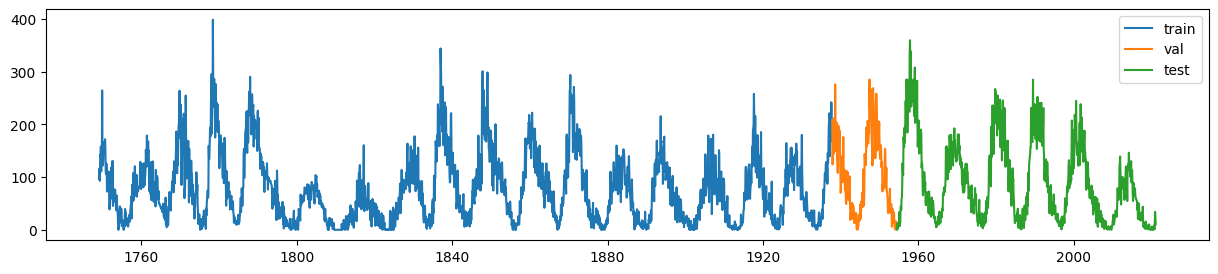

In [5]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(train_time, train_series, label='train')
ax.plot(val_time, val_series, label='val')
ax.plot(test_time, test_series, label='test')
ax.legend()
plt.show()

In [6]:
train_generator = TimeseriesGenerator(
    train_series, 
    train_series,
    length=WINDOW_SIZE, 
    sampling_rate=1,
    stride=1,
    batch_size=BATCH_SIZE
)

val_generator = TimeseriesGenerator(
    val_series, 
    val_series,
    length=WINDOW_SIZE, 
    sampling_rate=1,
    stride=1,
    batch_size=BATCH_SIZE
)

test_generator = TimeseriesGenerator(
    test_series, 
    test_series,
    length=WINDOW_SIZE, 
    sampling_rate=1,
    stride=1,
    batch_size=BATCH_SIZE
)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.LSTM(2, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [8]:
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=N_EPOCHS, 
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            mode='min')
    ]
)

Epoch 1/10


c:\users\robet\venvs\.deepl\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2145/2145 ━━━━━━━━━━━━━━━━━━━━ 102s 44ms/step - loss: 33547.6367 - val_loss: 12821.8535
Epoch 2/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 107s 50ms/step - loss: 7541.2124 - val_loss: 9680.7598
Epoch 3/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 100s 47ms/step - loss: 5409.3833 - val_loss: 3545.1797
Epoch 4/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 87s 41ms/step - loss: 1550.3669 - val_loss: 836.3984
Epoch 5/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 104s 49ms/step - loss: 729.5140 - val_loss: 825.3960
Epoch 6/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 112s 52ms/step - loss: 693.5759 - val_loss: 819.6774
Epoch 7/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 98s 45ms/step - loss: 691.0684 - val_loss: 865.9399
Epoch 8/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 96s 45ms/step - loss: 661.0906 - val_loss: 820.4743


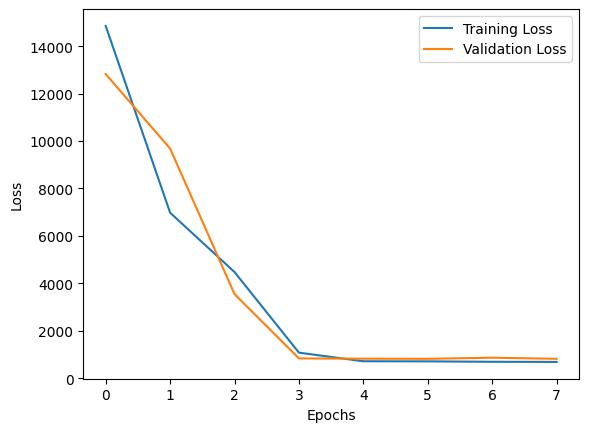

In [9]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.legend()
plt.show()

In [10]:
test_predictions = model.predict(test_generator)
train_predictions = model.predict(train_generator)
val_predictions = model.predict(val_generator)

680/680 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


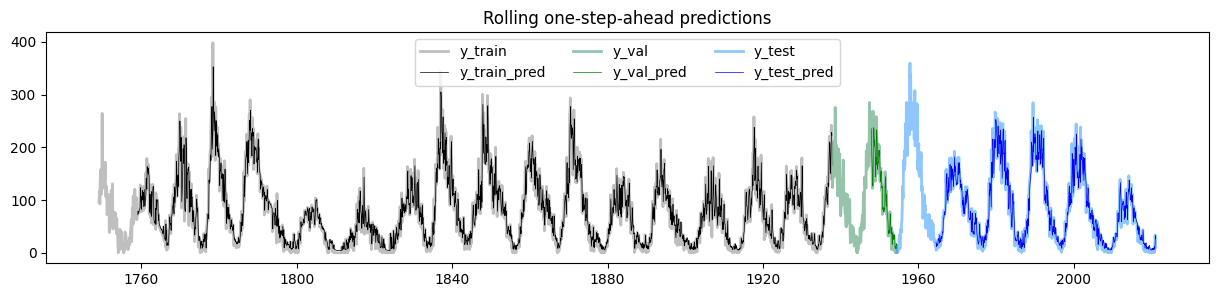

In [11]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(train_time, train_series, color='gray', linewidth=2, alpha=0.5, label='y_train')
ax.plot(train_time[WINDOW_SIZE:], train_predictions, color='black', linewidth=0.5, label='y_train_pred')
ax.plot(val_time, val_series, color='seagreen', linewidth=2, alpha=0.5, label='y_val')
ax.plot(val_time[WINDOW_SIZE:], val_predictions, color='green', linewidth=0.5, label='y_val_pred')
ax.plot(test_time, test_series, color='dodgerblue', linewidth=2, alpha=0.5, label='y_test')
ax.plot(test_time[WINDOW_SIZE:], test_predictions, color='blue', linewidth=0.5, label='y_test_pred')
ax.legend(ncol=3)
ax.set_title('Rolling one-step-ahead predictions')
plt.show()